# Загрузка библиотек

Для начала, были загружены все необходимые для работы библиотеки:

In [363]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from umap import UMAP
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 

from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_validate
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

from sklearn.naive_bayes import GaussianNB
from lazypredict.Supervised import LazyClassifier, LazyRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.inspection import permutation_importance

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from typing import Any

from scipy.stats import mannwhitneyu
from scipy.stats import ranksums
import shap

In [2]:
sns.set(rc={'figure.figsize':(10,10)})

# Загрузка исходных данных

После, была загружена заранее подготовленная база данных в csv формате (db_antibac_nps.csv):

In [18]:
bac_df = pd.read_csv('./Input_data/db_antibac_nps.csv', sep='\t').fillna('None')

In [19]:
bac_df

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,references,"f(n,c,j,s)obs",concentration,biological_activity
0,Escherichia coli,ATCC25922,SiO2,Spherical,DMA,Single,Monomer,60.08,13.37,2.93,2.33,98.50,18,Langmuir 2012; 28 (20) 7646–7656,0,MIC (uM),16644.47
1,Escherichia coli,ATCC25922,SiO2,Spherical,DMA,Single,Monomer,60.08,13.37,2.93,2.33,98.50,18,Langmuir 2012; 28 (20) 7646–7656,0,MIC (uM),16644.47
2,Escherichia coli,ATCC25922,SiO2,Spherical,DMA,Single,Monomer,60.08,13.37,2.93,2.33,98.50,18,Langmuir 2012; 28 (20) 7646–7656,0,MIC (uM),16644.47
3,Escherichia coli,ATCC25922,SiO2,Spherical,DMA,Single,Monomer,60.08,13.37,2.93,2.33,98.50,18,Langmuir 2012; 28 (20) 7646–7656,0,MIC (uM),16644.47
4,Escherichia coli,ATCC25922,SiO2,Spherical,DMA,Single,Monomer,60.08,13.37,2.93,2.33,98.50,18,Langmuir 2012; 28 (20) 7646–7656,0,MIC (uM),16644.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5322,Escherichia coli,K-12,CdS,Spherical,None,None,None,144.48,14.30,2.13,5.05,3.00,24,J. Hazard. Mater. 2013; 260 1073-1082,1,IC50 (uM),89.98
5323,Escherichia coli,K-12,CdS,Spherical,None,None,None,144.48,14.30,2.13,5.05,3.00,24,J. Hazard. Mater. 2013; 260 1073-1082,0,IC50 (uM),89.98
5324,Escherichia coli,K-12,CdS,Spherical,None,None,None,144.48,14.30,2.13,5.05,3.00,24,J. Hazard. Mater. 2013; 260 1073-1082,0,IC50 (uM),89.98
5325,Escherichia coli,K-12,CdS,Spherical,None,None,None,144.48,14.30,2.13,5.05,3.00,24,J. Hazard. Mater. 2013; 260 1073-1082,0,IC50 (uM),89.98


Выведем названия колонок для более удобной работы с данными:

In [20]:
bac_df.columns

Index(['pathogen', 'strain', 'composition', 'shape_np', 'coating', 'coating_n',
       'mono_poly', 'molar_mass', 'molar_volumes', 'electronegativities',
       'polarizabilities', 'size_np', 'time', 'references', 'f(n,c,j,s)obs',
       'concentration', 'biological_activity'],
      dtype='object')

Далее создаем индекс датафрейма:

In [21]:
bac_df.index = [f'id_{i}' for i in range(bac_df.shape[0])]

# EDA

**Разведочный анализ данных** (англ. exploratory data analysis, EDA) — анализ основных свойств данных, нахождение в них общих закономерностей, распределений и аномалий, построение начальных моделей, зачастую с использованием инструментов визуализации.
   

## Оценка непрерывных переменных

**Персентили** Сортируем изначальный вектор по возрастанию. Разделяем его на 100 последовательных ранвых частей. Первые 25 частей -- 25 перцентиль (25%). 50 перцентиль == медиана

In [23]:
bac_df.describe()

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",biological_activity
count,5327.00,5327.00,5327.00,5327.00,5327.00,5327.00,5327.00,5327.00
mean,143.09,10.60,2.42,5.84,13.37,23.16,0.11,716.32
std,55.68,1.69,0.30,1.55,14.70,4.03,0.31,1792.50
min,60.08,7.10,1.93,2.33,1.80,2.00,0.00,0.24
25%,79.87,10.20,1.95,3.84,2.20,24.00,0.00,31.33
50%,144.48,10.30,2.54,6.10,7.00,24.00,0.00,173.03
75%,196.97,10.55,2.54,6.70,25.00,24.00,0.00,628.58
max,325.81,17.40,2.95,12.92,98.50,24.00,1.00,16644.47


## Наличие пропусков

**Пропуски в данных** имеют отрицательное влияние на машинное обучение, потому что они могут привести к недостоверности или неточности в модели. Если данные с пропусками используются для обучения модели, то она может обучиться на неправильных закономерностях или иметь низкую точность.

In [24]:
bac_df.isna().sum(axis = 0)

pathogen               0
strain                 0
composition            0
shape_np               0
coating                0
coating_n              0
mono_poly              0
molar_mass             0
molar_volumes          0
electronegativities    0
polarizabilities       0
size_np                0
time                   0
references             0
f(n,c,j,s)obs          0
concentration          0
biological_activity    0
dtype: int64

Видим, что пропусков уже нет, так как они были заполнены заранее.

## Изучение дубликатов

**Дубликаты** в данных могут отрицательно влиять на обучение модели, потому что они могут привести к переобучению модели. Если в обучающем наборе данных имеются дубликаты, то модель может обучиться на них и как результат - иметь высокую точность, но плохо предсказывать новые данные. Так же, дубликаты могут занимать много места в памяти и замедлять процесс обучения.

In [25]:
bac_df.duplicated().sum()

4957

Кажется, в базе данных большинство строк - дубликаты. Грустно:( Нам придётся от них избавиться.

In [26]:
bac_df.shape[0] - bac_df.duplicated().sum()

370

Теперь строк стало более чем в 14 раз меньше...кажется, кому-то придётся дополнять бд руками:') 
Но, чтобы труд авторов статьи, из которой мы взяли базу данных, не пропал даром, сделаем колонку которая будет показывать, сколько раз проводился данный эксперимент, то есть количество раз, сколько встречается данная строка в изначальной таблице:

In [28]:
df_unique = bac_df.groupby(bac_df.columns.tolist()).size().reset_index(name='counts')

In [29]:
df_unique

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,references,"f(n,c,j,s)obs",concentration,biological_activity,counts
0,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943,0,MBC (uM),40.62,12
1,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943,0,MIC (uM),10.15,10
2,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943,0,MBC (uM),20.31,14
3,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943,0,MIC (uM),10.15,10
4,Acinetobacter baumannii,MDR,Au,Spherical,PDT/CPB,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943,0,MBC (uM),20.31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,Staphylococcus epidermidis,MET-S,Ag,Spherical,Galactose,Single,Monomer,107.87,10.30,1.93,7.90,50.00,24,J. Phys. Chem. B 2006; 110 (33) 16248-16253,0,MIC (uM),62.58,10
366,Staphylococcus epidermidis,MET-S,Ag,Spherical,Glucose,Single,Monomer,107.87,10.30,1.93,7.90,44.00,24,J. Phys. Chem. B 2006; 110 (33) 16248-16253,0,MIC (uM),125.15,9
367,Staphylococcus epidermidis,MET-S,Ag,Spherical,Lactose,Single,Monomer,107.87,10.30,1.93,7.90,35.00,24,J. Phys. Chem. B 2006; 110 (33) 16248-16253,0,MIC (uM),62.58,9
368,Staphylococcus epidermidis,MET-S,Ag,Spherical,Maltose,Single,Monomer,107.87,10.30,1.93,7.90,25.00,24,J. Phys. Chem. B 2006; 110 (33) 16248-16253,0,MIC (uM),15.67,9


In [30]:
df_unique.duplicated().sum()

0

Больше дубликатов нет, переходим к следущему шагу.

### Распределение количества экспериментов

Посмотрим чуть детальнее на распределение колличества экспериментов. Так, есть, например, 8 экспериментов, которые проводились 67 раз:

In [31]:
df_unique['counts'].value_counts().sort_index()

7      5
8     67
9     25
10    66
11    44
12    31
13    17
14     6
15     7
16    10
17     6
18     6
19     8
20    12
21     8
22     9
23    17
24     7
25     2
49     1
50     3
51     8
52     4
53     1
Name: counts, dtype: int64

Для наглядности построим гистограмму:

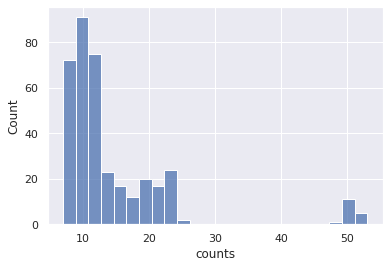

In [33]:
sns.histplot(data=df_unique, x='counts');

## Корреляция

**Корреляция** — это статистическая взаимосвязь двух или более величин, при этом изменения значений одной или нескольких из этих величин сопутствуют систематическому изменению значений другой или других величин.
Наличие сильно коррелирующих параметров может привести к проблемам в обучении модели, так как они могут давать схожие информацию о целевой переменной. Это может приводить к неопределенности в коэффициентах регрессии и в итоге модель может иметь низкую точность или быть чрезмерно обобщенной.

Корреляция определеяется через ковариацию так, как показано ниже:

$\text{r}_{XY} = \frac{\text{cov}_{XY}}{\sigma_X \sigma_Y}$

Где $\text{cov}_{XY}$ -- это:

$\text{cov}_{XY} = \mathbb{M}[ (X - \mathbb{M}(X))((Y - \mathbb{M}(Y))) ]$

In [34]:
df_unique.corr()

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",biological_activity,counts
molar_mass,1.00,0.14,0.44,0.12,-0.65,0.10,0.24,-0.38,-0.36
molar_volumes,0.14,1.00,0.21,-0.23,0.19,-0.27,-0.03,0.08,0.16
electronegativities,0.44,0.21,1.00,-0.79,-0.27,-0.12,0.06,0.02,0.04
polarizabilities,0.12,-0.23,-0.79,1.00,-0.04,0.09,0.07,-0.21,-0.27
size_np,-0.65,0.19,-0.27,-0.04,1.00,-0.25,-0.16,0.33,0.16
time,0.10,-0.27,-0.12,0.09,-0.25,1.00,0.08,-0.39,-0.12
"f(n,c,j,s)obs",0.24,-0.03,0.06,0.07,-0.16,0.08,1.00,-0.15,-0.33
biological_activity,-0.38,0.08,0.02,-0.21,0.33,-0.39,-0.15,1.00,0.21
counts,-0.36,0.16,0.04,-0.27,0.16,-0.12,-0.33,0.21,1.00


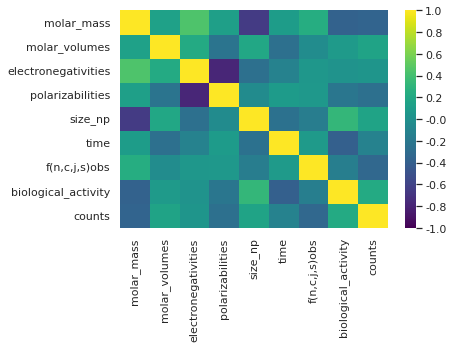

In [35]:
ax = sns.heatmap(df_unique.corr(), vmin=-1, vmax=1, cmap='viridis')
cbar = ax.collections[0].colorbar
cbar.set_ticks(np.arange(-1, 1.2, 0.2))
cbar.set_ticklabels([str(np.round(val, 1)) for val in np.arange(-1, 1.2, 0.2, dtype=float)]);

In [36]:
# Создание единичной матрицы размеров матрицы корреляции
diag_matrix = np.zeros((df_unique.corr().values.shape))
np.fill_diagonal(diag_matrix, 1)

# Вычитыем единицы с главной диагонали, чтобы смотреть смысловые корреляции
(df_unique.corr() - diag_matrix).abs().max().max()

0.7852787198355743

По числовым фичам была построена матрица корреляции и визуализирована с помощью heatmap'а. Как видим на визуализации, рассматриваемые фичи можем считать попарно линейно независимыми. Максимальное абсолютное значение корреляции составило: `0.7852787198355743`

In [37]:
0.7852787198355743 ** 2

0.6166626678265984

Так как мы изначально имеем не очень много фичей, а значение корреляции составляет около 0.79 ($R^2 \approx 0.62$), то не имеет большого смысла удалять одну из этих переменных.

### Electronegativities-Polarizabilities

Посмотрим, как связаны между собой две переменные, имеющие наибольшую линейную связь

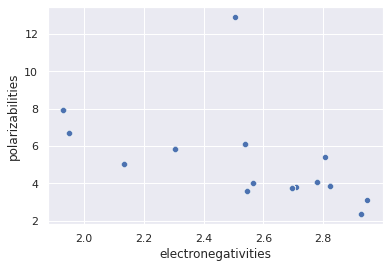

In [38]:
sns.scatterplot(x='electronegativities', y='polarizabilities', data=df_unique);

Видим наличие <i>тренда</i> на наличие линейной связи, а также явного выборса.

Посмотрим на выброс:

In [39]:
df_unique.loc[df_unique.loc[:, 'polarizabilities'] == df_unique.loc[:, 'polarizabilities'].max(), :].shape

(1, 18)

In [40]:
pol_el_outlier_to_check = df_unique.loc[df_unique.loc[:, 'polarizabilities'] == df_unique.loc[:, 'polarizabilities'].max(), :]

Видим, что все эти точки соответствуют одному референсу.

<b>Посмотрим на остальные точки с таким же составом:</b>

In [42]:
df_unique.query('composition == "La2O3"').equals(pol_el_outlier_to_check)

True

Видим, что эта точка, которая выглядит как выброс на скаттерплоте, соответствует `comp_np == "La2O3"`, который является единственной точкой в данных. То есть скорее всего это не выброс, а точка имеет физический смысл.

## BoxPlots

**Boxplot (также известный как "ящик с усами")** - это графическое представление для отображения статистики набора данных. Он показывает медиану, минимум, максимум и диапазон данных, а также выбросы (значения, которые значительно отличаются от других значений).

### Распределение биоактивности в зависимости от состава

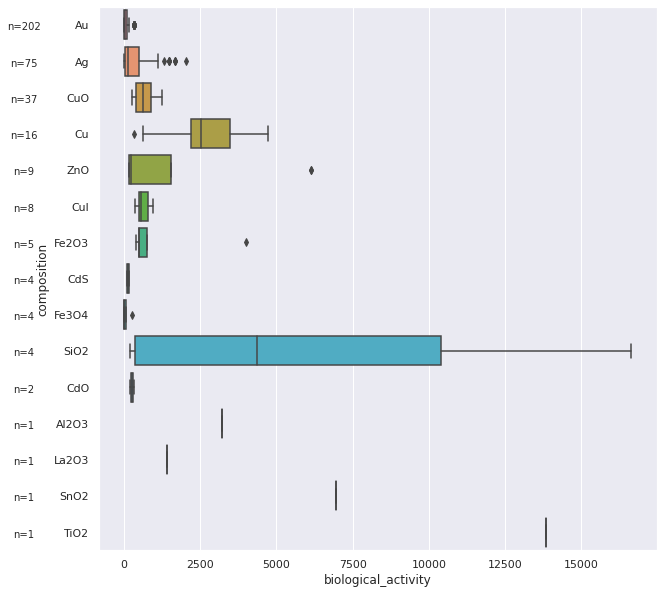

In [43]:
comp_np_counts = df_unique.value_counts('composition')
sort_order = df_unique.value_counts('composition').index.tolist()

plt.figure(figsize=(10,10))
sns.boxplot(data=df_unique, y="composition", x="biological_activity", order=sort_order)
for i in range(len(comp_np_counts)):
    plt.annotate(f'n={comp_np_counts[i]}', (0, i), xytext=(-100, -5), textcoords='offset points', ha='center', fontsize=10)

Видим, что у `SiO2` большой разброс биоактивности.
У `Au` больше всего точек, при этом его значения весьма консервативны.
А у `Al2O3`, `La2O3`, `SnO2` и `TiO2` из-за маленького количества данных боксплот напоминает линию.

### Распределене f(n,c,j,s)obs составам НЧ и оболочек

Посмотрим на распределение значений параметра `f(n,c,j,s)obs` в зависимости от состава НЧ и оболочек:

In [47]:
def df_comp_nomalized(df: pd.DataFrame, comp: str) -> pd.DataFrame:
    df_comp = df_unique.query('composition == @comp')

    # Count all entries for all scores and all categories
    a = df_comp.groupby(['coating', "f(n,c,j,s)obs"]).size() 
    # Normalize
    b = df_comp.groupby("coating")['f(n,c,j,s)obs'].count()
    df_comp_normalized = a.div(b).unstack() 
    return df_comp_normalized

In [48]:
comps = df_unique.value_counts('composition').index.tolist()

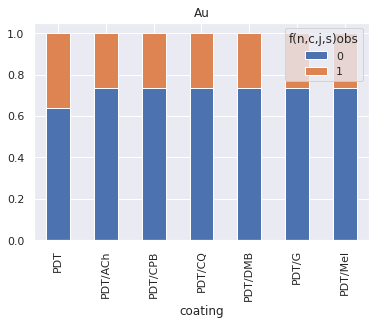

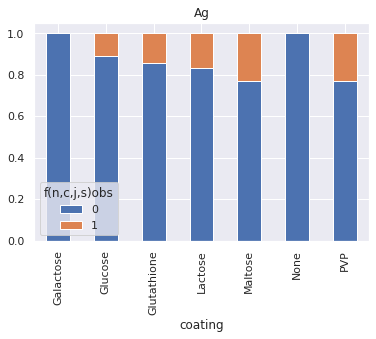

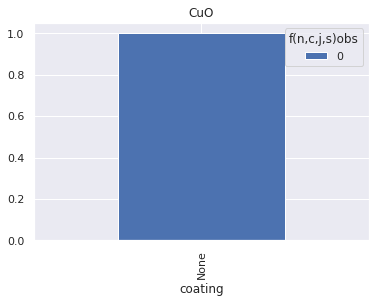

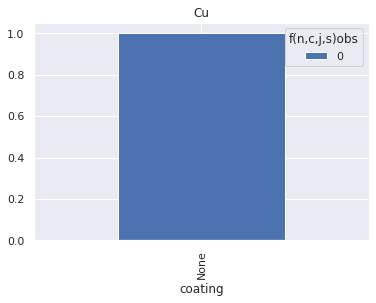

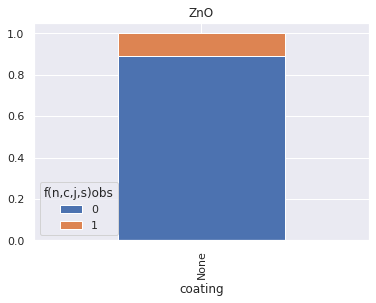

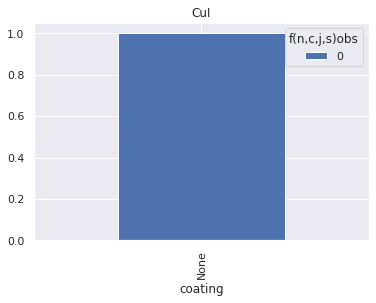

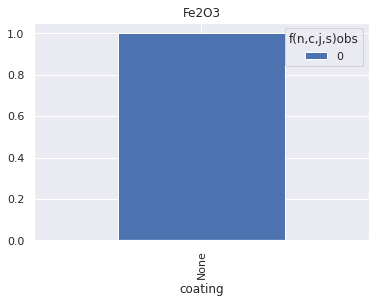

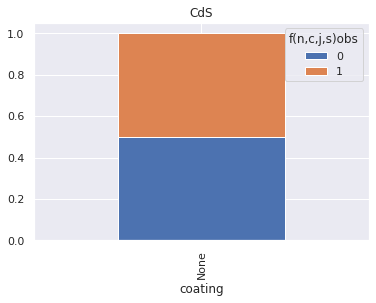

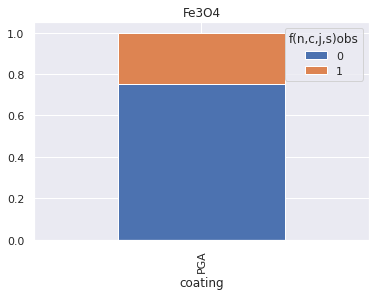

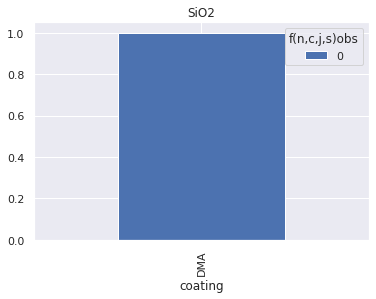

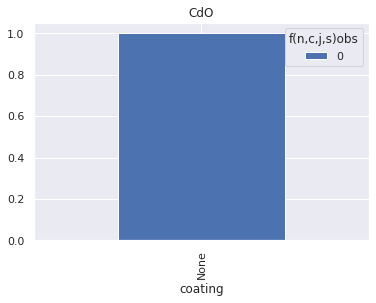

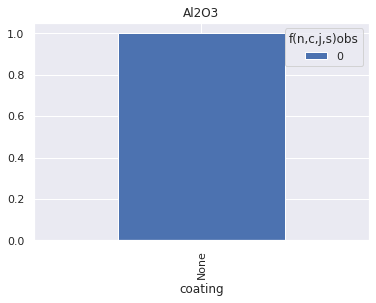

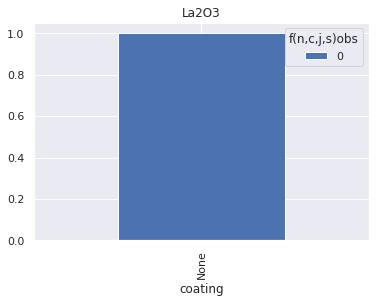

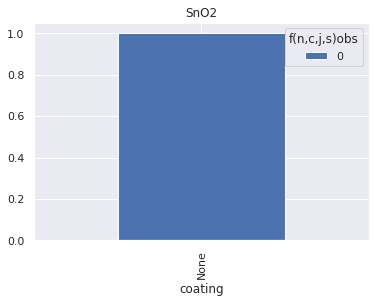

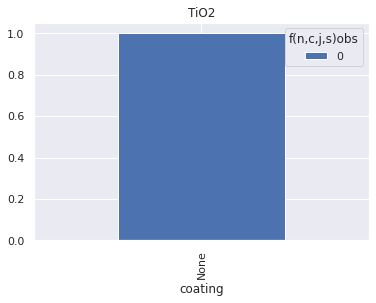

In [50]:
for i, comp in enumerate(comps):
    df_comp = df_comp_nomalized(df_unique, comp)
    df_comp.plot.bar(stacked=True)
    plt.title(comp)
    plt.show();

Из визуализации видно, что далеко не для всех составов наночастиц и оболочек достаточно данных, поэтому распределение 1 и 0 выглядит подобным образом.

# Encoding

Передадим состав наночастицы через ее физические свойства: `molar_mass`,	`molar_vol`,	`electro_negativ`,	`polarizabilities`.

In [ ]:
comp_np_df = df_unique[['comp_np', 'molar_mass', 'molar_vol', 'electro_negativ', 'polarizabilities']].drop_duplicates()
comp_np_df

In [68]:
df_unique1 = df_unique.drop('references', axis=1)
df_unique1

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",concentration,biological_activity,counts
0,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,0,MBC (uM),40.62,12
1,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,0,MIC (uM),10.15,10
2,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MBC (uM),20.31,14
3,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MIC (uM),10.15,10
4,Acinetobacter baumannii,MDR,Au,Spherical,PDT/CPB,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MBC (uM),20.31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,Staphylococcus epidermidis,MET-S,Ag,Spherical,Galactose,Single,Monomer,107.87,10.30,1.93,7.90,50.00,24,0,MIC (uM),62.58,10
366,Staphylococcus epidermidis,MET-S,Ag,Spherical,Glucose,Single,Monomer,107.87,10.30,1.93,7.90,44.00,24,0,MIC (uM),125.15,9
367,Staphylococcus epidermidis,MET-S,Ag,Spherical,Lactose,Single,Monomer,107.87,10.30,1.93,7.90,35.00,24,0,MIC (uM),62.58,9
368,Staphylococcus epidermidis,MET-S,Ag,Spherical,Maltose,Single,Monomer,107.87,10.30,1.93,7.90,25.00,24,0,MIC (uM),15.67,9


## One-Hot Encoding

**One-hot encoding** - это способ кодирования категориальных переменных (переменных, которые принимают ограниченное число значений) в виде бинарных векторов. Каждое значение категории кодируется в отдельный бинарный вектор, где значение 1 соответствует категории, а значение 0 - остальным категориям.

In [69]:
bac_df_ohe = pd.get_dummies(df_unique1.drop(['pathogen'], axis=1))
bac_df_ohe = pd.merge(bac_df_ohe, df_unique1[['pathogen']], left_index=True, right_index=True)

In [70]:
bac_df_ohe

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",biological_activity,counts,strain_ATCC10536,...,coating_n_None,coating_n_Single,mono_poly_Monomer,mono_poly_None,mono_poly_Polymer,concentration_IC50 (uM),concentration_MBC (uM),concentration_MIC (uM),concentration_Microb-Eff,pathogen
0,196.97,10.20,2.54,6.10,3.20,24,0,40.62,12,0,...,0,1,1,0,0,0,1,0,0,Acinetobacter baumannii
1,196.97,10.20,2.54,6.10,3.20,24,0,10.15,10,0,...,0,1,1,0,0,0,0,1,0,Acinetobacter baumannii
2,196.97,10.20,2.54,6.10,2.20,24,0,20.31,14,0,...,0,0,1,0,0,0,1,0,0,Acinetobacter baumannii
3,196.97,10.20,2.54,6.10,2.20,24,0,10.15,10,0,...,0,0,1,0,0,0,0,1,0,Acinetobacter baumannii
4,196.97,10.20,2.54,6.10,2.20,24,0,20.31,13,0,...,0,0,1,0,0,0,1,0,0,Acinetobacter baumannii
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,107.87,10.30,1.93,7.90,50.00,24,0,62.58,10,0,...,0,1,1,0,0,0,0,1,0,Staphylococcus epidermidis
366,107.87,10.30,1.93,7.90,44.00,24,0,125.15,9,0,...,0,1,1,0,0,0,0,1,0,Staphylococcus epidermidis
367,107.87,10.30,1.93,7.90,35.00,24,0,62.58,9,0,...,0,1,1,0,0,0,0,1,0,Staphylococcus epidermidis
368,107.87,10.30,1.93,7.90,25.00,24,0,15.67,9,0,...,0,1,1,0,0,0,0,1,0,Staphylococcus epidermidis


## Понижение размерности

**Понижение размерности** - это метод, который используется для уменьшения количества признаков в данных, но при этом придерживаясь как можно большей части информации из данных.

In [112]:
bac_df_ohe.dtypes

molar_mass                  float64
molar_volumes               float64
electronegativities         float64
polarizabilities            float64
size_np                     float64
time                          int64
biological_activity         float64
counts                        int64
strain_ATCC10536              uint8
strain_ATCC11775              uint8
strain_ATCC25922              uint8
strain_ATCC27853              uint8
strain_ATCC8739               uint8
strain_ATCC9027               uint8
strain_K-12                   uint8
strain_MD                     uint8
strain_MDR                    uint8
composition_Ag                uint8
composition_Au                uint8
composition_CdS               uint8
composition_Fe3O4             uint8
composition_ZnO               uint8
shape_np_Acicular             uint8
shape_np_Spherical            uint8
coating_Galactose             uint8
coating_Glucose               uint8
coating_Glutathione           uint8
coating_Lactose             

In [113]:
df_continuous = bac_df_ohe.select_dtypes(exclude=['object'])

### PCA

**PCA (Principal Component Analysis, Анализ главных компонент)** - это метод понижения размерности, который используется в машинном обучении для снижения количества признаков в данных.

PCA ищет новые направления (компоненты) в данных, которые содержат наибольшую дисперсию (разброс) данных. Эти новые направления являются линейными комбинациями старых признаков и называются главными компонентами. При этом, первая главная компонента объясняет наибольшую часть дисперсии в данных, вторая - наибольшую часть оставшейся дисперсии и так далее.

**Нормализация** - это процесс, который используется для изменения масштаба данных, чтобы сделать их более пригодными для использования в машинном обучении.
Используем **Z-score**, где каждый признак нормализуется за счет вычитания среднего значения и деления на стандартное отклонение.

*Нормализация -- вычитаем из каждой точки mean,
Стандартизация -- делим полученное на sd*

$z_{i} = \frac{x_i - \overline{x}}{sd}$

In [114]:
pca = PCA(n_components=2)
x = StandardScaler().fit_transform(df_continuous)
Xt = pd.DataFrame(pca.fit_transform(x), columns=['Axis_1', 'Axis_2'])

In [115]:
Xt['composition'] = df_unique.reset_index()['composition']
Xt['references'] = df_unique.reset_index()['references']

In [116]:
Xt

,Axis_1,Axis_2,composition,references
0,3.73,-3.89,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
1,-1.25,-0.17,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
2,-0.96,-0.79,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
3,-2.30,0.66,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
4,-2.00,0.05,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
...,...,...,...,...
150,4.04,-3.84,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
151,3.87,-3.75,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
152,5.15,-3.74,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943
153,8.99,11.95,Au,J. Am. Chem. Soc. 2013; 135 (35) 12940–12943


Визуализируем полученное:

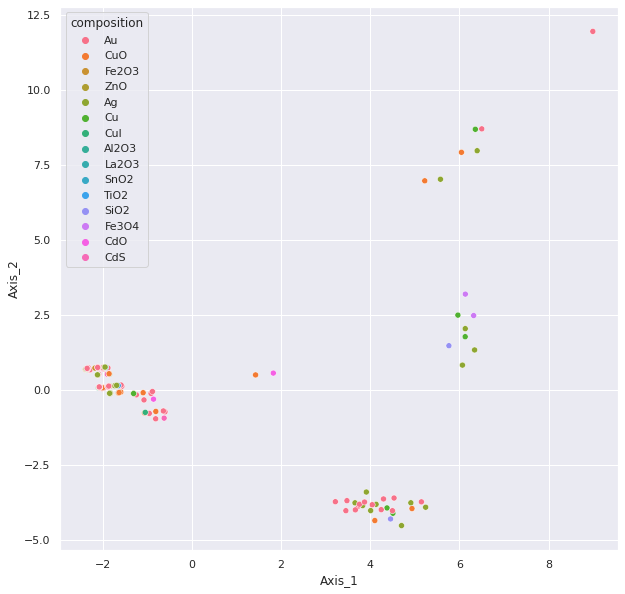

In [117]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=Xt, x="Axis_1", y="Axis_2", hue='composition');

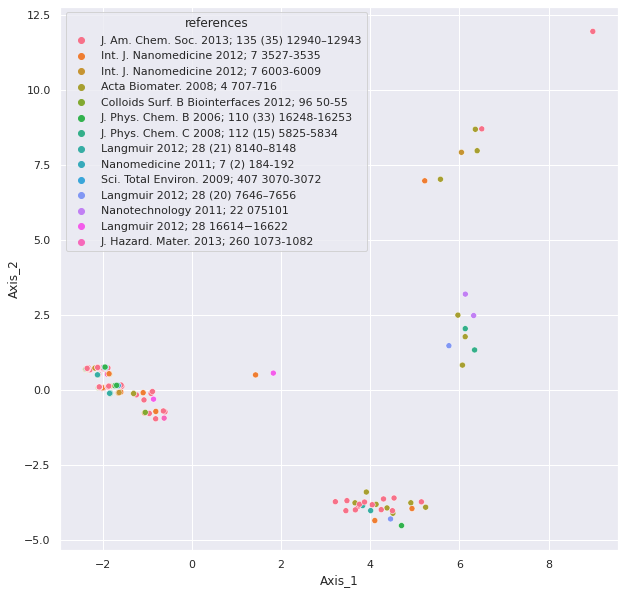

In [118]:
plt.figure(figsize=(10,10))

sns.scatterplot(data=Xt, x="Axis_1", y="Axis_2", hue='references');

На PCA видим, что есть тенденция к группированию. Покрасив по референсу и составу, видим, что эти параметры отражают группы.
Важно отметить, что PCA ищет линеные связи.

### UMAP

**UMAP** (Uniform Manifold Approximation and Projection) - это метод визуализации и понижения размерности, который используется в машинном обучении для отображения многомерных данных в двух или трехмерное пространство.
UMAP отличается от других методов понижения размерности, таких как **PCA**, тем, что он пытается сохранить локальную структуру данных в новом пространстве признаков. Это означает, что объекты, которые были близко расположены в исходном пространстве, будут близко расположены и в новом пространстве.

In [119]:
embedding = UMAP(n_components=2,random_state=42, n_epochs=800, verbose=True, n_jobs=8).fit_transform(df_continuous)


UMAP(n_epochs=800, n_jobs=8, random_state=42, verbose=True)
Tue Jan 17 15:23:38 2023 Construct fuzzy simplicial set
Tue Jan 17 15:23:39 2023 Finding Nearest Neighbors
Tue Jan 17 15:23:39 2023 Finished Nearest Neighbor Search
Tue Jan 17 15:23:39 2023 Construct embedding


Epochs completed:   0%|            0/800 [00:00]

Tue Jan 17 15:23:40 2023 Finished embedding


In [120]:
Xt_UMAP = pd.DataFrame(embedding, columns=['Axis_1', 'Axis_2'])
Xt_UMAP['references'] = df_unique.reset_index()['references']
Xt_UMAP['composition'] = df_unique.reset_index()['composition']

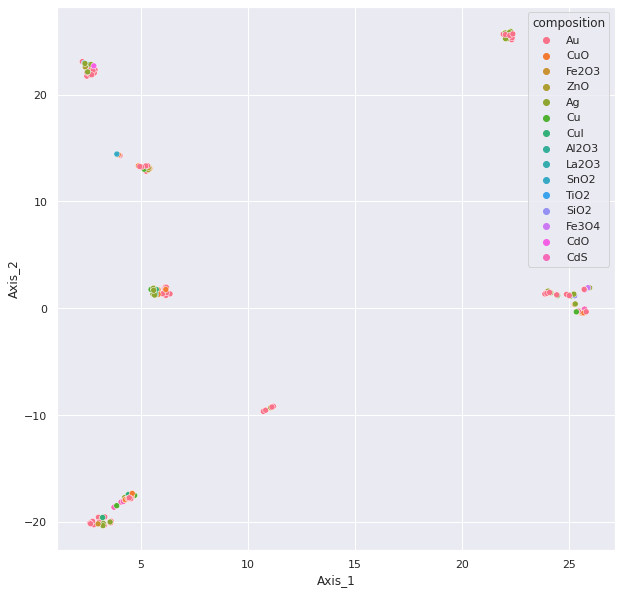

In [121]:
plt.figure(figsize=(10,10))
sns.scatterplot(data=Xt_UMAP, x="Axis_1", y="Axis_2", hue='composition');

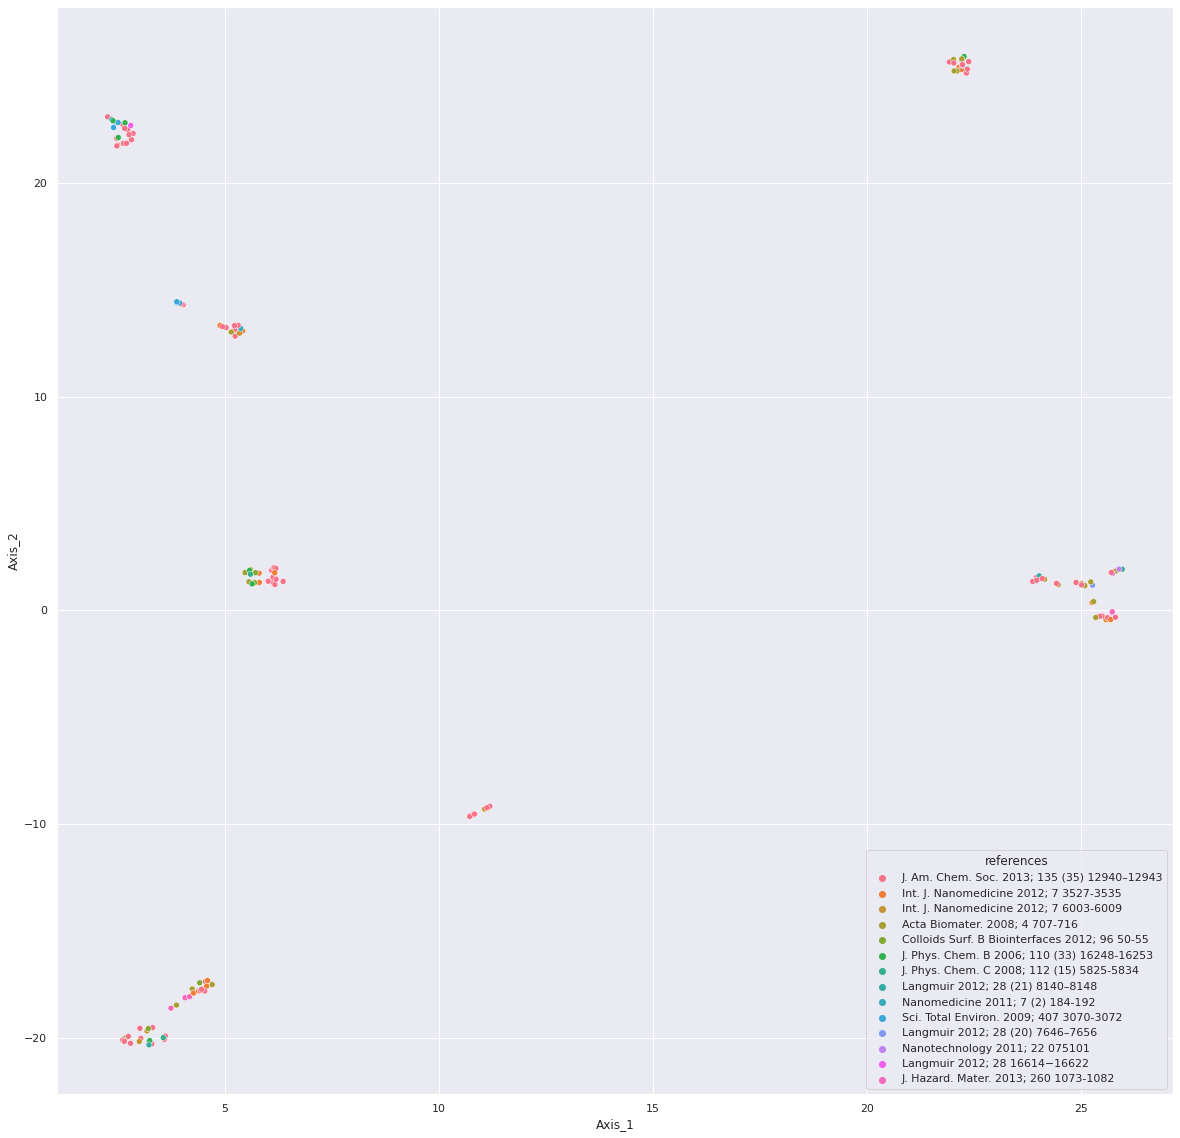

In [122]:
plt.figure(figsize=(20,20))
sns.scatterplot(data=Xt_UMAP, x="Axis_1", y="Axis_2", hue='references');

# Interesting bacs

In [123]:
resulted_true = df_unique1[df_unique1['f(n,c,j,s)obs'] == 1]
resulted_true.drop_duplicates(inplace=True)
resulted_true

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",concentration,biological_activity,counts
52,Escherichia coli,ATCC10536,Ag,Spherical,Glutathione,Single,Monomer,107.87,10.30,1.93,7.90,7.00,24,1,Microb-Eff,1.38,8
62,Escherichia coli,ATCC11775,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,1,MBC (uM),81.23,8
63,Escherichia coli,ATCC11775,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,1,MIC (uM),20.31,9
66,Escherichia coli,ATCC11775,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,1,MBC (uM),10.15,7
67,Escherichia coli,ATCC11775,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,1,MIC (uM),10.15,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,Pseudomonas aeruginosa,MDR,Au,Spherical,PDT/DMB,Double,Monomer,196.97,10.20,2.54,6.10,2.50,24,1,MIC (uM),20.31,8
275,Pseudomonas aeruginosa,MDR,Au,Spherical,PDT/G,Double,Monomer,196.97,10.20,2.54,6.10,2.00,24,1,MBC (uM),81.23,8
276,Pseudomonas aeruginosa,MDR,Au,Spherical,PDT/G,Double,Monomer,196.97,10.20,2.54,6.10,2.00,24,1,MIC (uM),40.62,8
279,Pseudomonas aeruginosa,MDR,Au,Spherical,PDT/Mel,Double,Monomer,196.97,10.20,2.54,6.10,1.80,24,1,MBC (uM),81.23,8


In [124]:
resulted_true.groupby(['pathogen', 'strain']).count()

composition  shape_np  coating  coating_n  \
pathogen               strain                                                 
Escherichia coli       ATCC10536            1         1        1          1   
                       ATCC11775           14        14       14         14   
                       ATCC25922            2         2        2          2   
                       ATCC8739             1         1        1          1   
                       K-12                 2         2        2          2   
                       MDR                 14        14       14         14   
Pseudomonas aeruginosa ATCC27853           17        17       17         17   
                       MD                   5         5        5          5   
                       MDR                 14        14       14         14   

                                  mono_poly  molar_mass  molar_volumes  \
pathogen               strain                                            
Escherichia coli       ATCC10536          1           1              1   
                       ATCC11775         14          14             14   
                       ATCC25922          2           2              2   
                       ATCC8739           1           1              1   
                       K-12               2           2              2   
                       MDR               14          14             14   
Pseudomonas aeruginosa ATCC27853         17          17             17   
                       MD                 5           5              5   
                       MDR               14          14             14   

                                  electronegativities  polarizabilities  \
pathogen               strain                                             
Escherichia coli       ATCC10536                    1                 1   
                       ATCC11775                   14                14   
                       ATCC25922                    2                 2   
                       ATCC8739                     1                 1   
                       K-12                         2                 2   
                       MDR                         14                14   
Pseudomonas aeruginosa ATCC27853                   17                17   
                       MD                           5                 5   
                       MDR                         14                14   

                                  size_np  time  f(n,c,j,s)obs  concentration  \
pathogen               strain                                                   
Escherichia coli       ATCC10536        1     1              1              1   
                       ATCC11775       14    14             14             14   
                       ATCC25922        2     2              2              2   
                       ATCC8739         1     1              1              1   
                       K-12             2     2              2              2   
                       MDR             14    14             14             14   
Pseudomonas aeruginosa ATCC27853       17    17             17             17   
                       MD               5     5              5              5   
                       MDR             14    14             14             14   

                                  biological_activity  counts  
pathogen               strain                                  
Escherichia coli       ATCC10536                    1       1  
                       ATCC11775                   14      14  
                       ATCC25922                    2       2  
                       ATCC8739                     1       1  
                       K-12                         2       2  
                       MDR                         14      14  
Pseudomonas aeruginosa ATCC27853                   17      17  
                       MD                           5  

In [125]:
resulted_true.value_counts('pathogen')

pathogen
Pseudomonas aeruginosa    36
Escherichia coli          34
dtype: int64

In [126]:
resulted_true.groupby('pathogen').value_counts(['composition'])

pathogen                composition
Escherichia coli        Au             28
                        Ag              3
                        CdS             2
                        Fe3O4           1
Pseudomonas aeruginosa  Au             28
                        Ag              7
                        ZnO             1
dtype: int64

При анализе данных стало заметно, что параметр `f(n,c,j,s)obs` лишь для двух бактерий принимает значение 1 и имеет более или менее равномерное распределение (примерно 50 на 50).
Для других бактерий нет примеров строк, в которых этот параметр принимал бы значение 1, а значит на таких данных мы не сможем корректно обучить модель. 
Было принято решение обучать модель только на данных, где присутствуют "единицы". Это бактерии `Escherichia coli` и `Pseudomonas aeruginosa`.

# Add zeros

Мы создали выборку только со строками для этих бактерий, в которых этот параметр был равен 1. Так что теперь, чтобы уравновесить бд, нужно добавить 0.

In [127]:
result_false = df_unique1[df_unique1['f(n,c,j,s)obs'] == 0]
result_false

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",concentration,biological_activity,counts
0,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,0,MBC (uM),40.62,12
1,Acinetobacter baumannii,MDR,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,0,MIC (uM),10.15,10
2,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MBC (uM),20.31,14
3,Acinetobacter baumannii,MDR,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MIC (uM),10.15,10
4,Acinetobacter baumannii,MDR,Au,Spherical,PDT/CPB,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,0,MBC (uM),20.31,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
365,Staphylococcus epidermidis,MET-S,Ag,Spherical,Galactose,Single,Monomer,107.87,10.30,1.93,7.90,50.00,24,0,MIC (uM),62.58,10
366,Staphylococcus epidermidis,MET-S,Ag,Spherical,Glucose,Single,Monomer,107.87,10.30,1.93,7.90,44.00,24,0,MIC (uM),125.15,9
367,Staphylococcus epidermidis,MET-S,Ag,Spherical,Lactose,Single,Monomer,107.87,10.30,1.93,7.90,35.00,24,0,MIC (uM),62.58,9
368,Staphylococcus epidermidis,MET-S,Ag,Spherical,Maltose,Single,Monomer,107.87,10.30,1.93,7.90,25.00,24,0,MIC (uM),15.67,9


## EC

`Escherichia coli`:

In [128]:
result_false_EC = result_false[result_false.pathogen == 'Escherichia coli']
result_false_EC.shape

(81, 17)

Кроме того, не для всех составов НЧ есть строки, где параметр `f(n,c,j,s)obs` равен 1, поэтому далее приведем список составов НЧ, для которых в базе есть данные:

### Au

In [129]:
result_false_EC_Au = result_false_EC[result_false_EC.composition == 'Au']

### Ag

In [130]:
result_false_EC_Ag = result_false_EC[result_false_EC.composition == 'Ag']

### CdS

In [131]:
result_false_EC_CdS = result_false_EC[result_false_EC.composition == 'CdS']

### Fe3O4

In [132]:
result_false_EC_Fe3O4 = result_false_EC[result_false_EC.composition == 'Fe3O4']

## PA

То же самое сделаем и для `Pseudomonas aeruginosa`:

In [133]:
result_false_PA = result_false[result_false.pathogen == 'Pseudomonas aeruginosa']

### Au

In [134]:
result_false_PA_Au = result_false_PA[result_false_PA.composition == 'Au']

### Ag

In [135]:
result_false_PA_Ag = result_false_PA[result_false_PA.composition == 'Ag']

### ZnO

In [136]:
result_false_PA_ZnO = result_false_PA[result_false_PA.composition == 'ZnO']

## Negative_example_df

Составим выборку из выбранных выше строк:

In [137]:
n_e_df = pd.concat([result_false_EC_Au, result_false_EC_Ag, result_false_EC_CdS, result_false_EC_Fe3O4,
                   result_false_PA_Au, result_false_PA_Ag, result_false_PA_ZnO])

In [138]:
already_included_indices = n_e_df.index.tolist()

In [139]:
#additional_to_nef = result_false[~result_false.index.isin(already_included_indices)].sample(df.shape[0] - n_e_df.shape[0])

In [140]:
#n_e_df = pd.concat([n_e_df, additional_to_nef])

# Mean params

Посмотрим на средние параметры и построим `violinplot` для наглядности:

In [264]:
df_regr.dtypes

pathogen                object
strain                  object
composition             object
shape_np                object
coating                 object
coating_n               object
mono_poly               object
molar_mass             float64
molar_volumes          float64
electronegativities    float64
polarizabilities       float64
size_np                float64
time                     int64
f(n,c,j,s)obs            int64
concentration           object
biological_activity    float64
counts                   int64
dtype: object

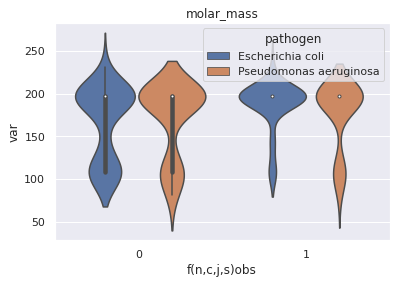

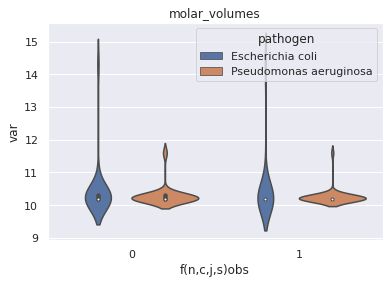

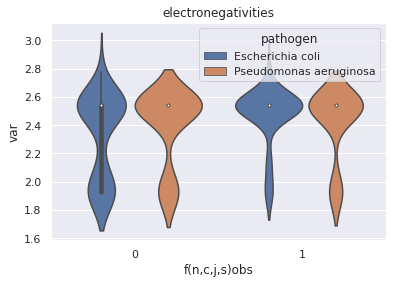

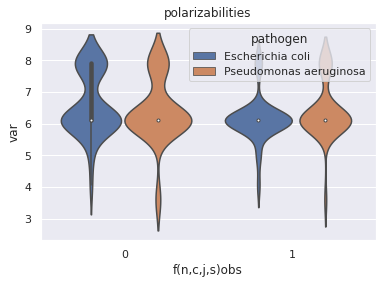

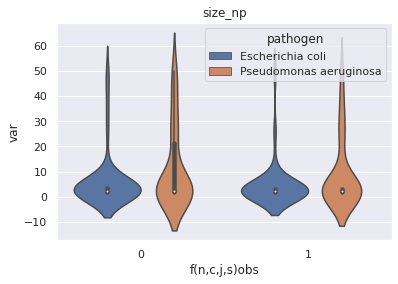

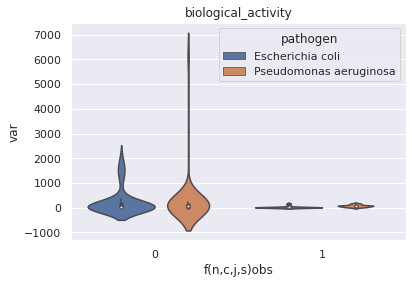

In [294]:
for col in df_regr.columns.tolist():
    if (df_regr[col].dtypes.name == 'float64') and col != 'f(n,c,j,s)obs ':
        plt.figure()
        plt.title(col)
        vec = df_regr[col]
        tmp_df = pd.DataFrame({'var': vec, 
                               'f(n,c,j,s)obs': df_regr['f(n,c,j,s)obs'],
                              'pathogen': df_regr['pathogen']})
        sns.violinplot(x='f(n,c,j,s)obs', y='var', hue='pathogen', data=tmp_df)

Построим также `boxplot`:

In [265]:
df_regr.columns

Index(['pathogen', 'strain', 'composition', 'shape_np', 'coating', 'coating_n',
       'mono_poly', 'molar_mass', 'molar_volumes', 'electronegativities',
       'polarizabilities', 'size_np', 'time', 'f(n,c,j,s)obs', 'concentration',
       'biological_activity', 'counts'],
      dtype='object')

In [268]:
tmp_df = pd.DataFrame({'biological_activity': df_regr.biological_activity, 
                               'f(n,c,j,s)obs': df_regr['f(n,c,j,s)obs'],
                              'pathogen': df_regr['pathogen']})

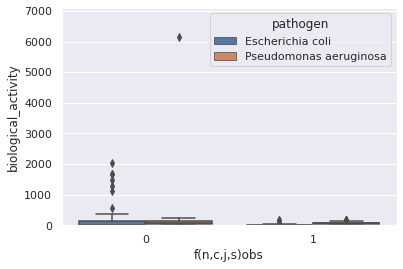

In [272]:
sns.boxplot(x='f(n,c,j,s)obs', y='biological_activity', hue='pathogen', data=tmp_df)
plt.ylim((0, 7100));

Видим выброс, посмотрим на него детальнее:

In [276]:
df_regr.query('biological_activity > 6000')

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",concentration,biological_activity,counts
231,Pseudomonas aeruginosa,ATCC9027,ZnO,Acicular,None,None,None,81.41,11.60,2.54,3.60,25.00,24,0,MIC (uM),6141.90,16


Построим, ограничившись значениями до 2200:

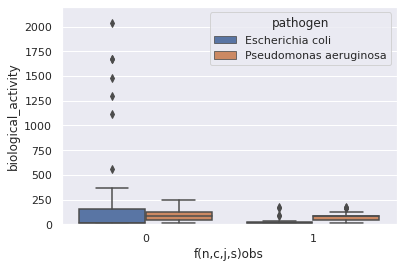

In [273]:
sns.boxplot(x='f(n,c,j,s)obs', y='biological_activity', hue='pathogen', data=tmp_df)
plt.ylim((0, 2200));

## Stat-test. Comapre Biological Activity

**Stat-test** (статистический тест) используется в машинном обучении для проверки гипотезы о том, что две выборки имеют одинаковое распределение. Это может быть полезно для проверки статистической значимости результатов модели или для сравнения её с результатами другой модели.

p-value: это вероятность того, что наблюдаемое различие между двумя выборками может быть объяснено случайным флуктуациями. Чем меньше p-value, тем меньше вероятность того, что различие является случайным и следовательно тем более статистически значимым.

### EC

In [279]:
tmp_df

,biological_activity,"f(n,c,j,s)obs",pathogen
52,1.38,1,Escherichia coli
62,81.23,1,Escherichia coli
63,20.31,1,Escherichia coli
66,10.15,1,Escherichia coli
67,10.15,1,Escherichia coli
...,...,...,...
235,125.15,0,Pseudomonas aeruginosa
237,31.33,0,Pseudomonas aeruginosa
239,15.67,0,Pseudomonas aeruginosa
231,6141.90,0,Pseudomonas aeruginosa


In [284]:
ba_ES_f_1 = tmp_df.loc[(tmp_df['f(n,c,j,s)obs'] == 1) & ((tmp_df['pathogen'] == 'Escherichia coli')), 'biological_activity']
ba_ES_f_0 = tmp_df.loc[(tmp_df['f(n,c,j,s)obs'] == 0) & ((tmp_df['pathogen'] == 'Escherichia coli')), 'biological_activity']
tmp_df.query('pathogen == "Escherichia coli"').shape[0] == ba_ES_f_1.shape[0] + ba_ES_f_0.shape[0]


U1, p = mannwhitneyu(ba_ES_f_1, 
                     ba_ES_f_0, method="auto")

print(f'U-statistic = {U1}')
print(f'M-W p-value = {p}')

U-statistic = 614.0
M-W p-value = 0.08386413563786212


Нет оснований отвергнуть нулевую гипотезу о том, что обе выборки взяты из одной генеральной совокупности на уровне значимости 0.05

### PA

In [293]:
ba_PA_f_1 = tmp_df.loc[(tmp_df['f(n,c,j,s)obs'] == 1) & ((tmp_df['pathogen'] == 'Pseudomonas aeruginosa')), 'biological_activity']
ba_PA_f_0 = tmp_df.loc[(tmp_df['f(n,c,j,s)obs'] == 0) & ((tmp_df['pathogen'] == 'Pseudomonas aeruginosa')), 'biological_activity']
tmp_df.query('pathogen == "Pseudomonas aeruginosa"').shape[0] == ba_PA_f_1.shape[0] + ba_PA_f_0.shape[0]


U1, p = mannwhitneyu(ba_PA_f_1, 
                     ba_PA_f_0, method="auto")

print(f'U-statistic = {U1}')
print(f'M-W p-value = {p}')

U-statistic = 648.0
M-W p-value = 0.5562338935132907


# Regression

In [259]:
df_regr = pd.concat([resulted_true, n_e_df])
df_regr

,pathogen,strain,composition,shape_np,coating,coating_n,mono_poly,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,"f(n,c,j,s)obs",concentration,biological_activity,counts
52,Escherichia coli,ATCC10536,Ag,Spherical,Glutathione,Single,Monomer,107.87,10.30,1.93,7.90,7.00,24,1,Microb-Eff,1.38,8
62,Escherichia coli,ATCC11775,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,1,MBC (uM),81.23,8
63,Escherichia coli,ATCC11775,Au,Spherical,PDT,Single,Monomer,196.97,10.20,2.54,6.10,3.20,24,1,MIC (uM),20.31,9
66,Escherichia coli,ATCC11775,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,1,MBC (uM),10.15,7
67,Escherichia coli,ATCC11775,Au,Spherical,PDT/ACh,Double,Monomer,196.97,10.20,2.54,6.10,2.20,24,1,MIC (uM),10.15,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,Pseudomonas aeruginosa,MD,Ag,Spherical,Lactose,Single,Monomer,107.87,10.30,1.93,7.90,35.00,24,0,MIC (uM),125.15,11
237,Pseudomonas aeruginosa,MD,Ag,Spherical,Maltose,Single,Monomer,107.87,10.30,1.93,7.90,25.00,24,0,MIC (uM),31.33,11
239,Pseudomonas aeruginosa,MD,Ag,Spherical,PVP,Single,Polymer,107.87,10.30,1.93,7.90,26.00,24,0,MIC (uM),15.67,12
231,Pseudomonas aeruginosa,ATCC9027,ZnO,Acicular,None,None,None,81.41,11.60,2.54,3.60,25.00,24,0,MIC (uM),6141.90,16


In [260]:
df_regr.value_counts('pathogen')

pathogen
Escherichia coli          80
Pseudomonas aeruginosa    75
dtype: int64

In [261]:
df_regr.columns

Index(['pathogen', 'strain', 'composition', 'shape_np', 'coating', 'coating_n',
       'mono_poly', 'molar_mass', 'molar_volumes', 'electronegativities',
       'polarizabilities', 'size_np', 'time', 'f(n,c,j,s)obs', 'concentration',
       'biological_activity', 'counts'],
      dtype='object')

In [262]:
bac_df_ohe = pd.get_dummies(df_regr.drop(['pathogen', 'f(n,c,j,s)obs'], axis=1))
bac_df_ohe = pd.merge(bac_df_ohe, df_regr[['pathogen', 'f(n,c,j,s)obs']], left_index=True, right_index=True)

## Clip

Делаем клип данных. То есть все значения больше чем 130 будут приравнивнены к 130, потому как это правая граница диапазона для биологической активности, когда мы можем считать это значение оптимальным.

In [299]:
y_clipped = np.clip(y, a_min=0, a_max=130)

Покажем, почему заклипали биоактивность

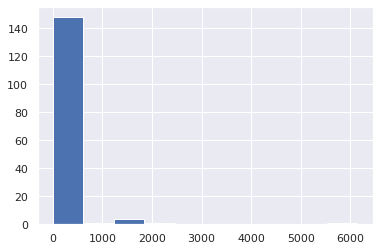

In [320]:
y.hist();

Видим, что почти все точки имеют низкую биоактивность, за исключением всего нескольких.

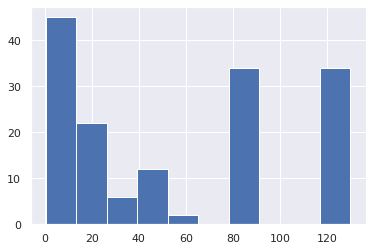

In [321]:
y_clipped.hist();
Ввод [320]:


После клипа данные выглядят более равномерно.

## RandomForest

Приступаем к обучению модели `Random Forest Regressor`:

In [296]:
bac_df_ohe

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,biological_activity,counts,strain_ATCC10536,strain_ATCC11775,...,coating_n_Single,mono_poly_Monomer,mono_poly_None,mono_poly_Polymer,concentration_IC50 (uM),concentration_MBC (uM),concentration_MIC (uM),concentration_Microb-Eff,pathogen,"f(n,c,j,s)obs"
52,107.87,10.30,1.93,7.90,7.00,24,1.38,8,1,0,...,1,1,0,0,0,0,0,1,Escherichia coli,1
62,196.97,10.20,2.54,6.10,3.20,24,81.23,8,0,1,...,1,1,0,0,0,1,0,0,Escherichia coli,1
63,196.97,10.20,2.54,6.10,3.20,24,20.31,9,0,1,...,1,1,0,0,0,0,1,0,Escherichia coli,1
66,196.97,10.20,2.54,6.10,2.20,24,10.15,7,0,1,...,0,1,0,0,0,1,0,0,Escherichia coli,1
67,196.97,10.20,2.54,6.10,2.20,24,10.15,8,0,1,...,0,1,0,0,0,0,1,0,Escherichia coli,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,107.87,10.30,1.93,7.90,35.00,24,125.15,11,0,0,...,1,1,0,0,0,0,1,0,Pseudomonas aeruginosa,0
237,107.87,10.30,1.93,7.90,25.00,24,31.33,11,0,0,...,1,1,0,0,0,0,1,0,Pseudomonas aeruginosa,0
239,107.87,10.30,1.93,7.90,26.00,24,15.67,12,0,0,...,1,0,0,1,0,0,1,0,Pseudomonas aeruginosa,0
231,81.41,11.60,2.54,3.60,25.00,24,6141.90,16,0,0,...,0,0,1,0,0,0,1,0,Pseudomonas aeruginosa,0


In [244]:
rfc = RandomForestClassifier(n_estimators=300,
                             random_state=42,
                             n_jobs=-1)

In [389]:
rfr = RandomForestRegressor(
    n_estimators=3000,
    random_state=42,
    n_jobs=-1)

In [390]:
X = bac_df_ohe.drop(['pathogen', 'biological_activity'], axis=1)
y = bac_df_ohe.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [391]:
preds_RF = cross_val_predict(rfr, X, y_clipped, cv=KFold(len(X)), n_jobs=-1)

In [392]:
MAE = metrics.mean_absolute_error(y_clipped, preds_RF)
RMSE = metrics.mean_squared_error(y_clipped, preds_RF)
R2 = metrics.r2_score(y_clipped, preds_RF)

In [394]:
print(f'LOO MAE = {MAE}')
print(f'LOO RMSE = {RMSE}')
print(f'LOO R2 = {R2}')

LOO MAE = 15.342787289362182
LOO RMSE = 613.5592204482468
LOO R2 = 0.7207285132872173


**MAE, RMSE и R2** - это три стандартные метрики, которые могут использоваться для оценки качества модели Random Forest Regressor.

- **MAE** (Mean Absolute Error) - это средняя абсолютная ошибка, которая показывает среднюю разницу между предсказанными и фактическими значениями.
- **RMSE** (Root Mean Squared Error) - это корень из среднеквадратичной ошибки, которая сосредоточена на больших отклонениях и показывает среднеквадратичное расстояние между предсказанным и фактическим значениями.
- **R2** (Coefficient of Determination) - это метрика, которая показывает, насколько хорошо модель объясняет данные. R2 принимает значения от 0 до 1, где 1 соответствует идеальной модели, которая совпадает с фактическими данными.

In [395]:
# MAE
((compare_preds.Predictions - compare_preds.True_labels).abs()).mean()

15.34278728936218

In [396]:
# RMSE
((compare_preds.Predictions - compare_preds.True_labels) ** 2).mean()

613.5592204482468

In [397]:
compare_preds = pd.DataFrame({'True_labels': y_clipped,
             'Predictions': preds_RF})
compare_preds

,True_labels,Predictions
52,1.38,34.72
62,81.23,73.79
63,20.31,50.95
66,10.15,11.93
67,10.15,10.32
...,...,...
235,125.15,113.58
237,31.33,38.23
239,15.67,25.66
231,130.00,120.64


In [398]:
compare_preds.describe()

,True_labels,Predictions
count,155.00,155.00
mean,56.79,56.56
std,47.02,39.40
min,0.42,9.20
25%,10.15,19.36
50%,40.62,49.25
75%,81.23,81.81
max,130.00,129.86


Видим, что полученная модель справляется не так хорошо, как хотелось бы, разобьем её на 2 отдельные в соответствии с патогеном.

# Split to 2 models

In [322]:
bac_df_ohe.value_counts('pathogen')

pathogen
Escherichia coli          80
Pseudomonas aeruginosa    75
dtype: int64

In [323]:
bac_df_ohe_EC = bac_df_ohe.query('pathogen == "Escherichia coli"').drop('pathogen', axis=1)
bac_df_ohe_PA = bac_df_ohe.query('pathogen == "Pseudomonas aeruginosa"').drop('pathogen', axis=1)

bac_df_ohe_EC = bac_df_ohe_EC[[c for c in bac_df_ohe_EC if c != 'biological_activity'] 
       + ['biological_activity']]
bac_df_ohe_PA = bac_df_ohe_PA[[c for c in bac_df_ohe_PA if c != 'biological_activity'] 
       + ['biological_activity']]

In [325]:
bac_df_ohe.shape[0] == bac_df_ohe_EC.shape[0] + bac_df_ohe_PA.shape[0]

True

## PA

Модель для `Pseudomonas aeruginosa`:

In [258]:
bac_df_ohe_PA

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,counts,strain_ATCC10536,strain_ATCC11775,strain_ATCC25922,...,coating_n_Single,mono_poly_Monomer,mono_poly_None,mono_poly_Polymer,concentration_IC50 (uM),concentration_MBC (uM),concentration_MIC (uM),concentration_Microb-Eff,"f(n,c,j,s)obs",biological_activity
198,107.87,10.30,1.93,7.90,35.00,24,8,0,0,0,...,1,1,0,0,0,0,1,0,1,125.15
200,107.87,10.30,1.93,7.90,50.00,24,8,0,0,0,...,1,1,0,0,0,0,1,0,1,62.58
202,107.87,10.30,1.93,7.90,26.00,24,8,0,0,0,...,1,0,0,1,0,0,1,0,1,15.67
205,196.97,10.20,2.54,6.10,3.20,24,8,0,0,0,...,1,1,0,0,0,1,0,0,1,162.46
206,196.97,10.20,2.54,6.10,3.20,24,8,0,0,0,...,1,1,0,0,0,0,1,0,1,81.23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,107.87,10.30,1.93,7.90,35.00,24,11,0,0,0,...,1,1,0,0,0,0,1,0,0,125.15
237,107.87,10.30,1.93,7.90,25.00,24,11,0,0,0,...,1,1,0,0,0,0,1,0,0,31.33
239,107.87,10.30,1.93,7.90,26.00,24,12,0,0,0,...,1,0,0,1,0,0,1,0,0,15.67
231,81.41,11.60,2.54,3.60,25.00,24,16,0,0,0,...,0,0,1,0,0,0,1,0,0,6141.90


In [328]:
X = bac_df_ohe_PA.drop(['biological_activity'], axis=1)
y = bac_df_ohe_PA.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [330]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

In [331]:
preds_RF = cross_val_predict(rfc, X, y_clipped, cv=KFold(len(X)), n_jobs=-1)

MAE = metrics.mean_absolute_error(y_clipped, preds_RF)
RMSE = metrics.mean_squared_error(y_clipped, preds_RF)
R2 = metrics.r2_score(y_clipped, preds_RF)

print(f'LOO MAE = {MAE}')
print(f'LOO RMSE = {RMSE}')
print(f'LOO R2 = {R2}')

LOO MAE = 10.861105288889261
LOO RMSE = 256.5560361428194
LOO R2 = 0.8180335042945754


Видим, что $R^2$ подрос! Это хорошо, движемся в правильном направлении. Масштабировать разбиение на несколько моделей - не является такой уж сложной задачей, так что будем продолжать считать для каждой бактерии отдельно.

## EC

Модель для `Escherichia coli`:

In [333]:
bac_df_ohe_EC

,molar_mass,molar_volumes,electronegativities,polarizabilities,size_np,time,counts,strain_ATCC10536,strain_ATCC11775,strain_ATCC25922,...,coating_n_Single,mono_poly_Monomer,mono_poly_None,mono_poly_Polymer,concentration_IC50 (uM),concentration_MBC (uM),concentration_MIC (uM),concentration_Microb-Eff,"f(n,c,j,s)obs",biological_activity
52,107.87,10.30,1.93,7.90,7.00,24,8,1,0,0,...,1,1,0,0,0,0,0,1,1,1.38
62,196.97,10.20,2.54,6.10,3.20,24,8,0,1,0,...,1,1,0,0,0,1,0,0,1,81.23
63,196.97,10.20,2.54,6.10,3.20,24,9,0,1,0,...,1,1,0,0,0,0,1,0,1,20.31
66,196.97,10.20,2.54,6.10,2.20,24,7,0,1,0,...,0,1,0,0,0,1,0,0,1,10.15
67,196.97,10.20,2.54,6.10,2.20,24,8,0,1,0,...,0,1,0,0,0,0,1,0,1,10.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,107.87,10.30,1.93,7.90,3.32,24,22,0,0,0,...,0,0,1,0,0,1,0,0,0,1483.29
114,107.87,10.30,1.93,7.90,3.32,24,22,0,0,0,...,0,0,1,0,0,0,1,0,0,1112.47
117,144.48,14.30,2.13,5.05,3.00,24,17,0,0,0,...,0,0,1,0,1,0,0,0,0,89.98
118,144.48,14.30,2.13,5.05,3.00,24,17,0,0,0,...,0,0,1,0,0,1,0,0,0,173.03


In [335]:
X = bac_df_ohe_EC.drop(['biological_activity'], axis=1)
y = bac_df_ohe_EC.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [336]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

In [337]:
preds_RF = cross_val_predict(rfc, X, y_clipped, cv=KFold(len(X)), n_jobs=-1)

MAE = metrics.mean_absolute_error(y_clipped, preds_RF)
RMSE = metrics.mean_squared_error(y_clipped, preds_RF)
R2 = metrics.r2_score(y_clipped, preds_RF)

print(f'LOO MAE = {MAE}')
print(f'LOO RMSE = {RMSE}')
print(f'LOO R2 = {R2}')

LOO MAE = 9.779581916666869
LOO RMSE = 467.92687553100495
LOO R2 = 0.790086625164199


Здесь видим аналогичную ситуацию!

Таким образом, разбиение на два датасета в соответствии с патогеном позволило повысить качество моделей!

## LazyPredict

Ради интереса попробуем также `LazyPredict`:

In [338]:
X = bac_df_ohe.drop(['pathogen', 'biological_activity'], axis=1)
y = bac_df_ohe.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [344]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.35, random_state=42)

In [345]:
clf = LazyRegressor(predictions=True,
                     verbose=len(X_train))

In [349]:
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

'tuple' object has no attribute '__name__'
Invalid Regressor(s)


  5%|▍         | 2/41 [00:00<00:02, 16.88it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.06776333403589074, 'Adjusted R-Squared': -9.06815599241238, 'RMSE': 810.4230949268017, 'Time taken': 0.08890986442565918}
{'Model': 'BaggingRegressor', 'R-Squared': 0.12067744726413854, 'Adjusted R-Squared': -8.496683569547304, 'RMSE': 787.0871545555402, 'Time taken': 0.029454946517944336}
{'Model': 'BayesianRidge', 'R-Squared': 0.10659481694158257, 'Adjusted R-Squared': -8.648775977030908, 'RMSE': 793.3648451344533, 'Time taken': 0.01909804344177246}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.07777835686894052, 'Adjusted R-Squared': -8.959993745815442, 'RMSE': 806.0581505799464, 'Time taken': 0.02109551429748535}
{'Model': 'DummyRegressor', 'R-Squared': -0.0038735853671536535, 'Adjusted R-Squared': -9.84183472196526, 'RMSE': 840.9849659653656, 'Time taken': 0.019475936889648438}
{'Model': 'ElasticNet', 'R-Squared': 0.09691081880450769, 'Adjusted R-Squared': -8.753363156911318, 'RMSE': 797.6530652127192, 'Time taken': 0.0222041606903

 17%|█▋        | 7/41 [00:00<00:01, 24.33it/s]

{'Model': 'ElasticNetCV', 'R-Squared': 0.09632095531372564, 'Adjusted R-Squared': -8.759733682611763, 'RMSE': 797.9135210055316, 'Time taken': 0.09692716598510742}
{'Model': 'ExtraTreeRegressor', 'R-Squared': 0.07758676000026687, 'Adjusted R-Squared': -8.962062991997119, 'RMSE': 806.1418778478139, 'Time taken': 0.01114344596862793}


 24%|██▍       | 10/41 [00:00<00:01, 22.48it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.06425631002185495, 'Adjusted R-Squared': -9.106031851763968, 'RMSE': 811.9460479223312, 'Time taken': 0.12336206436157227}
{'Model': 'GammaRegressor', 'R-Squared': 0.049772173528918606, 'Adjusted R-Squared': -9.262460525887679, 'RMSE': 818.2058696747936, 'Time taken': 0.01313328742980957}
{'Model': 'GaussianProcessRegressor', 'R-Squared': -0.05116307260418829, 'Adjusted R-Squared': -10.352561184125234, 'RMSE': 860.5651735292431, 'Time taken': 0.01905655860900879}
{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.06310368671927491, 'Adjusted R-Squared': -9.118480183431831, 'RMSE': 812.4459604136284, 'Time taken': 0.09570527076721191}


 41%|████▏     | 17/41 [00:07<00:11,  2.02it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.0882164756779148, 'Adjusted R-Squared': -8.84726206267852, 'RMSE': 801.4835051599608, 'Time taken': 6.347264528274536}
{'Model': 'HuberRegressor', 'R-Squared': 0.10860378076353816, 'Adjusted R-Squared': -8.627079167753788, 'RMSE': 792.472339521086, 'Time taken': 0.041853904724121094}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.2677460771237775, 'Adjusted R-Squared': -6.908342367063203, 'RMSE': 718.2565119708848, 'Time taken': 0.011723756790161133}
{'Model': 'KernelRidge', 'R-Squared': 0.03541129815187105, 'Adjusted R-Squared': -9.417557979959794, 'RMSE': 824.365492279068, 'Time taken': 0.0390925407409668}
{'Model': 'Lars', 'R-Squared': 0.09543583653288557, 'Adjusted R-Squared': -8.769292965444837, 'RMSE': 798.3041881323115, 'Time taken': 0.06374883651733398}


 51%|█████     | 21/41 [00:07<00:06,  3.21it/s]

{'Model': 'LarsCV', 'R-Squared': 0.122847578976779, 'Adjusted R-Squared': -8.473246147050787, 'RMSE': 786.1153052828867, 'Time taken': 0.08114790916442871}
{'Model': 'Lasso', 'R-Squared': 0.06257514494892713, 'Adjusted R-Squared': -9.124188434551588, 'RMSE': 812.6750952042272, 'Time taken': 0.010950565338134766}
{'Model': 'LassoCV', 'R-Squared': 0.06740323246622604, 'Adjusted R-Squared': -9.07204508936476, 'RMSE': 810.5796037096146, 'Time taken': 0.08977985382080078}
{'Model': 'LassoLars', 'R-Squared': 0.08021192122261367, 'Adjusted R-Squared': -8.933711250795772, 'RMSE': 804.9939323553915, 'Time taken': 0.012451648712158203}
{'Model': 'LassoLarsCV', 'R-Squared': 0.07767107092147696, 'Adjusted R-Squared': -8.96115243404805, 'RMSE': 806.105035294742, 'Time taken': 0.0380251407623291}
{'Model': 'LassoLarsIC', 'R-Squared': 0.10983035843175926, 'Adjusted R-Squared': -8.613832128937, 'RMSE': 791.9269235399348, 'Time taken': 0.018080711364746094}
{'Model': 'LinearRegression', 'R-Squared': 0.

 76%|███████▌  | 31/41 [00:07<00:01,  7.11it/s]

{'Model': 'MLPRegressor', 'R-Squared': -0.0014796420114169262, 'Adjusted R-Squared': -9.815980133723304, 'RMSE': 839.9816164905578, 'Time taken': 0.47301578521728516}
{'Model': 'NuSVR', 'R-Squared': -0.02464073473675099, 'Adjusted R-Squared': -10.06611993515691, 'RMSE': 849.639172558143, 'Time taken': 0.022415876388549805}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.06896573335557055, 'Adjusted R-Squared': -9.055170079759838, 'RMSE': 809.9002842347276, 'Time taken': 0.02083110809326172}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.0626701827207502, 'Adjusted R-Squared': -9.123162026615898, 'RMSE': 812.6338989486031, 'Time taken': 0.030005455017089844}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.07316791460300986, 'Adjusted R-Squared': -9.009786522287493, 'RMSE': 808.0704929940235, 'Time taken': 0.021694660186767578}
{'Model': 'PoissonRegressor', 'R-Squared': 0.06307438747373684, 'Adjusted R-Squared': -9.118796615283642, 'RMSE': 812.4586639899164, 'Time t

 83%|████████▎ | 34/41 [00:08<00:00,  7.90it/s]

{'Model': 'RANSACRegressor', 'R-Squared': 0.3375078761605269, 'Adjusted R-Squared': -6.15491493746631, 'RMSE': 683.1861891935364, 'Time taken': 0.09954094886779785}
{'Model': 'RandomForestRegressor', 'R-Squared': 0.11842589608742948, 'Adjusted R-Squared': -8.521000322255762, 'RMSE': 788.0941991389495, 'Time taken': 0.14497900009155273}
{'Model': 'Ridge', 'R-Squared': 0.1066278134919788, 'Adjusted R-Squared': -8.64841961428663, 'RMSE': 793.3501941422104, 'Time taken': 0.010082006454467773}
{'Model': 'RidgeCV', 'R-Squared': 0.10662781349227679, 'Adjusted R-Squared': -8.64841961428341, 'RMSE': 793.3501941420781, 'Time taken': 0.016804933547973633}


 93%|█████████▎| 38/41 [00:08<00:00, 10.70it/s]

{'Model': 'SGDRegressor', 'R-Squared': 0.10905889776502509, 'Adjusted R-Squared': -8.62216390413773, 'RMSE': 792.270008798174, 'Time taken': 0.03755068778991699}
{'Model': 'SVR', 'R-Squared': -0.03157105854739939, 'Adjusted R-Squared': -10.140967432311914, 'RMSE': 852.5076665304553, 'Time taken': 0.02336287498474121}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.10646411188571558, 'Adjusted R-Squared': -8.650187591634273, 'RMSE': 793.4228775960637, 'Time taken': 0.02198505401611328}
{'Model': 'TweedieRegressor', 'R-Squared': 0.0986645783205864, 'Adjusted R-Squared': -8.734422554137668, 'RMSE': 796.8781852287926, 'Time taken': 0.020972728729248047}
{'Model': 'XGBRegressor', 'R-Squared': 0.07552559203117881, 'Adjusted R-Squared': -8.984323606063269, 'RMSE': 807.04205282195, 'Time taken': 10.410208225250244}


100%|██████████| 41/41 [00:24<00:00,  1.67it/s]

{'Model': 'LGBMRegressor', 'R-Squared': 0.08412218969028118, 'Adjusted R-Squared': -8.891480351344963, 'RMSE': 803.2809861508093, 'Time taken': 5.820173025131226}


In [347]:
models.sort_values('R-Squared', ascending=False)

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
RANSACRegressor,-6.15,0.34,683.19,0.09
KNeighborsRegressor,-6.91,0.27,718.26,0.01
LarsCV,-8.47,0.12,786.12,0.08
BaggingRegressor,-8.50,0.12,787.09,0.03
RandomForestRegressor,-8.52,0.12,788.09,0.14
LassoLarsIC,-8.61,0.11,791.93,0.02
SGDRegressor,-8.62,0.11,792.27,0.04
HuberRegressor,-8.63,0.11,792.47,0.04
RidgeCV,-8.65,0.11,793.35,0.02


Как видим, `LazyPredict` не очень хорошо справился со своей работой, а жаль:(

## Feature Importance

**Feature importance** в машинном обучении используется для определения важности каждого признака в модели. Это может помочь улучшить качество модели, определить лишние или ненужные признаки, а также понять, как каждый признак влияет на предсказание.

### Permutation FI

**Permutation feature importance** (Permutation FI) является одним из методов оценки важности признаков в модели машинного обучения. Он основан на изменении метрики качества модели после случайной перестановки значений каждого признака. Если метрика качества значительно ухудшается после перестановки значений какого-либо признака, то этот признак считается важным для модели.

#### PA

In [350]:
X = bac_df_ohe_PA.drop(['biological_activity'], axis=1)
y = bac_df_ohe_PA.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [352]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

rfc.fit(X, y_clipped)

In [ ]:
perm_importance = permutation_importance(rfc, X, y, n_repeats=100, n_jobs=-1)

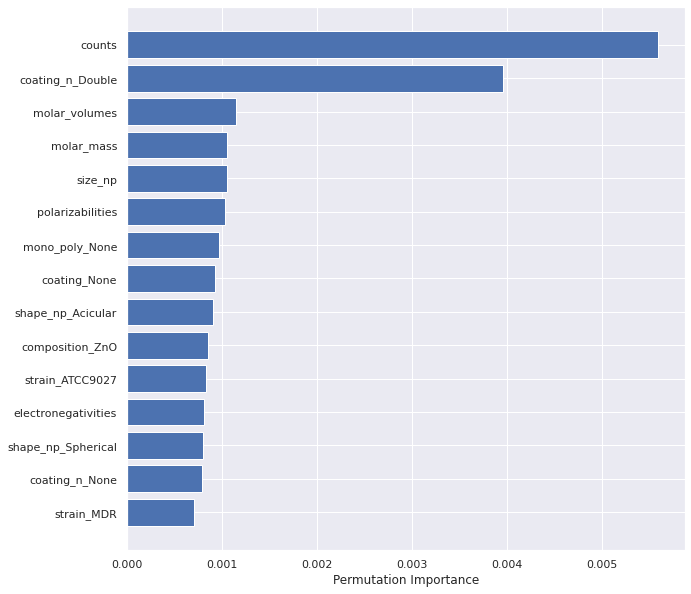

In [356]:
plt.figure(figsize=(10,10))
sorted_idx = perm_importance.importances_mean.argsort()[-15:]
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

Делаем вывод, что наиболее важными характеристиками для предсказания стали параметры: `counts` и `coating_n_Double`. Первый отражает количество повторов экспериментов, а второй - наличие двойной оболочки у НЧ.

#### EC

In [357]:
X = bac_df_ohe_EC.drop(['biological_activity'], axis=1)
y = bac_df_ohe_EC.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [358]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

rfc.fit(X, y_clipped)

RandomForestRegressor(n_estimators=3000, n_jobs=-1, random_state=42)

In [359]:
perm_importance = permutation_importance(rfc, X, y, n_repeats=100, n_jobs=-1)

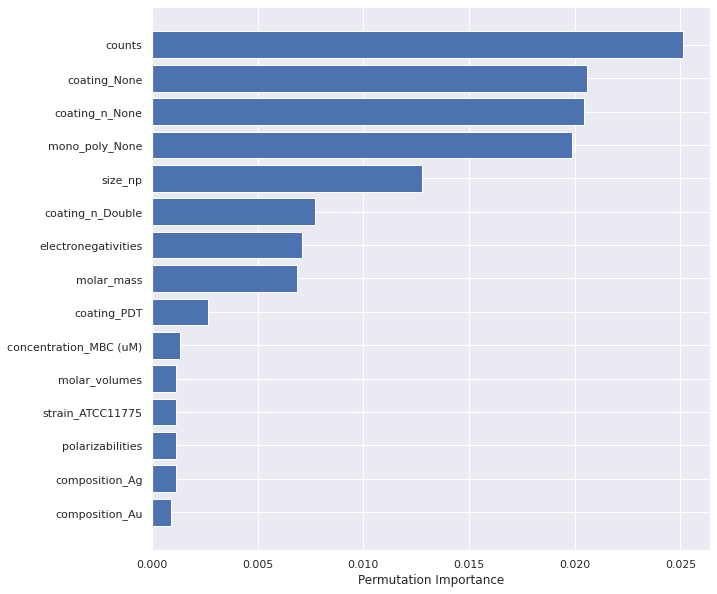

In [360]:
plt.figure(figsize=(10,10))
sorted_idx = perm_importance.importances_mean.argsort()[-15:]
plt.barh(X_test.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance");

В данном случае, делаем вывод, что наиболее важными характеристиками для предсказания стали параметры: `counts`, `coating_None`, `coaning_n_None` и `coating_poly_None`. Первый отражает количество повторов экспериментов, а остальные - состояние оболочки НЧ.

### SHAP FI

В библиотеке **SHAP** для оценки важности фичей рассчитываются значения Шэпли (по имени американского математика и названа библиотека).
Для оценки важности фичи происходит оценка предсказаний модели с и без данной фичи.

#### PA

In [362]:
X = bac_df_ohe_PA.drop(['biological_activity'], axis=1)
y = bac_df_ohe_PA.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [364]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

rfc.fit(X, y_clipped)

RandomForestRegressor(n_estimators=3000, n_jobs=-1, random_state=42)

In [366]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X)

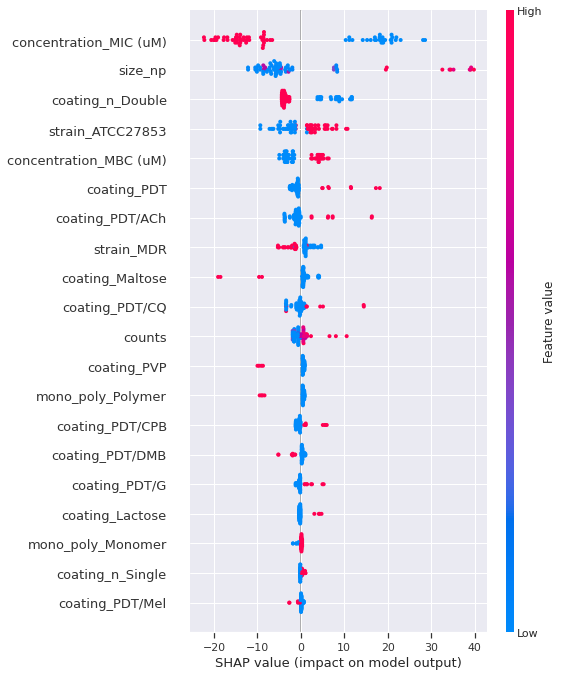

In [368]:
shap.summary_plot(shap_values, X)

Видим, что первым из числовых параметров стал `size_np` (размер НЧ), то есть чем меньше размер, тем меньше биологическая активность и наоборот.

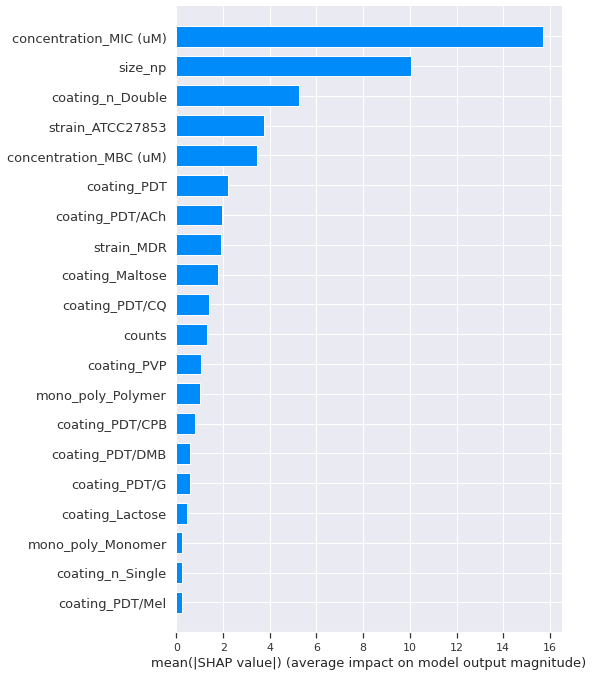

In [369]:
shap.summary_plot(shap_values, X, plot_type='bar')

#### EC

In [370]:
X = bac_df_ohe_EC.drop(['biological_activity'], axis=1)
y = bac_df_ohe_EC.biological_activity

y_clipped = np.clip(y, a_min=0, a_max=130)

In [371]:
rfc = RandomForestRegressor(n_estimators=3000,
                             random_state=42,
                             n_jobs=-1)

rfc.fit(X, y_clipped)

RandomForestRegressor(n_estimators=3000, n_jobs=-1, random_state=42)

In [372]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X)

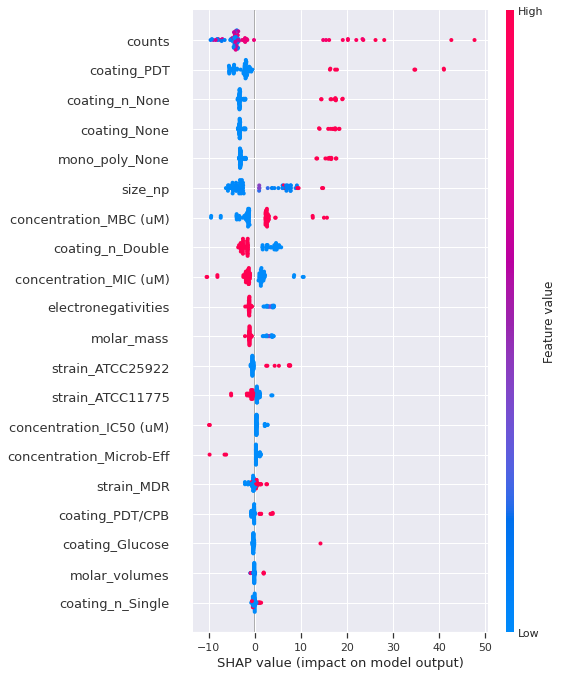

In [373]:
shap.summary_plot(shap_values, X)

В данном случае, вперед опять вырвалось количество проведенных экспериментов.
По параметру `coating_PDT` например можно сказать, что если оболочкой является не PDT, то результат скорее всего будет ниже.

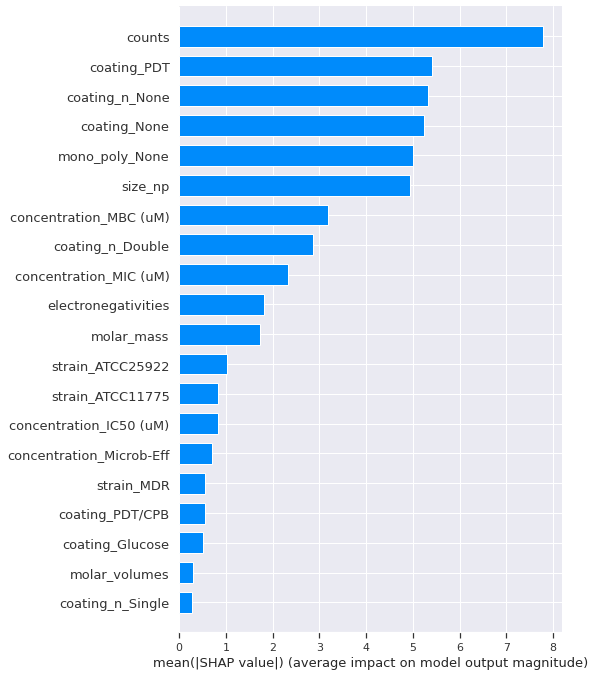

In [374]:
shap.summary_plot(shap_values, X, plot_type='bar')